<a href="https://colab.research.google.com/github/gauravgupt8/Data-Science-Dissertation/blob/main/Kidney_Early_Detection_Dissertation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import kagglehub

# Loading latest version data
path = kagglehub.dataset_download("nazmul0087/ct-kidney-dataset-normal-cyst-tumor-and-stone")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/ct-kidney-dataset-normal-cyst-tumor-and-stone


# Imports and Setup

In [ ]:
# ========================
# 1. Import and Setup Required modules
# ========================

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from PIL import Image
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, GlobalAveragePooling2D, AveragePooling2D
from tensorflow.keras.applications import MobileNetV2
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

warnings.filterwarnings("ignore")
print("Modules loaded.")


Modules loaded.


# Load Image Paths and Labels into a DataFrame

In [ ]:
# ===================================
# 2. Load Image Paths and Labels
# ===================================

data_dir = '/kaggle/input/ct-kidney-dataset-normal-cyst-tumor-and-stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone'

filepaths = []
labels = []

for folder in os.listdir(data_dir):
    class_folder = os.path.join(data_dir, folder)
    for filename in os.listdir(class_folder):
        filepaths.append(os.path.join(class_folder, filename))
        labels.append(folder)

df = pd.DataFrame({'filepath': filepaths, 'label': labels})
print("Dataset loaded with shape:", df.shape)


Dataset loaded with shape: (12446, 2)


# Basic Exploratory Data Analysis (EDA)

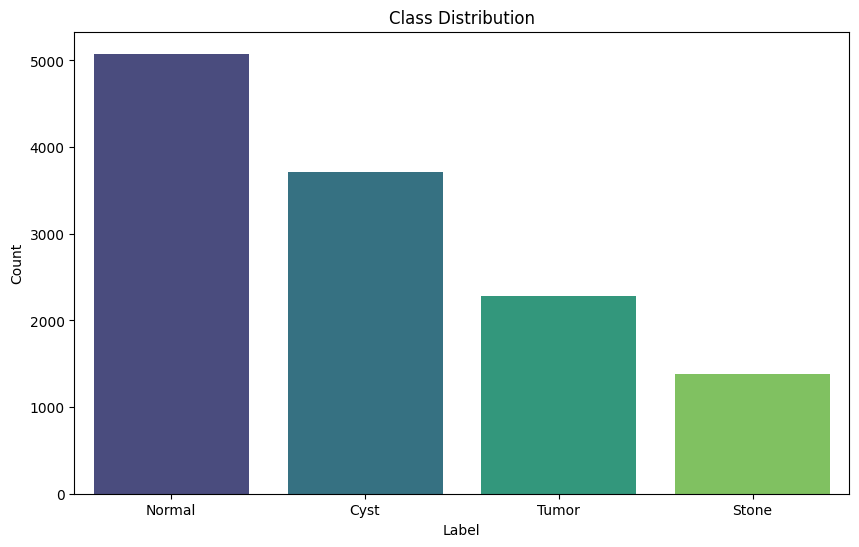

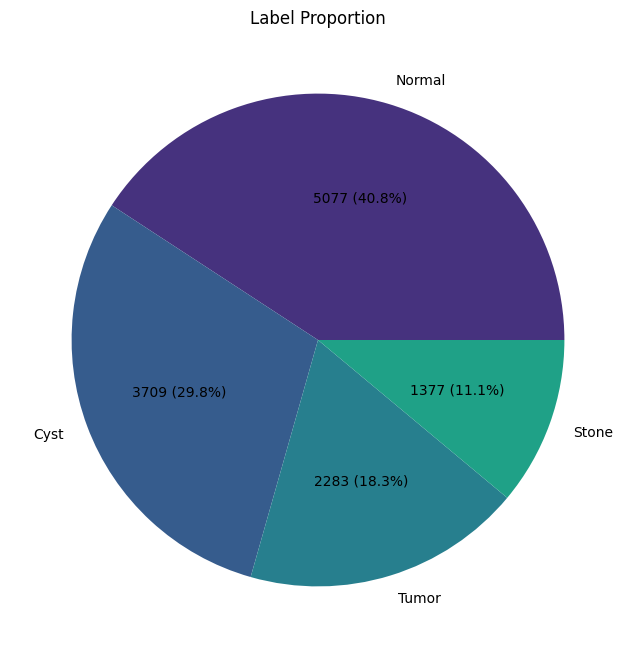

Duplicate filepaths: 0


In [ ]:
# ========================
# 3. Basic EDA
# ========================

# Plot class distribution bar chart
label_counts = df['label'].value_counts()
plt.figure(figsize=(10, 6))
sns.barplot(x=label_counts.index, y=label_counts.values, palette='viridis')
plt.title('Class Distribution')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

# Plot class distribution pie chart
plt.figure(figsize=(8, 8))
# plt.pie(label_counts.values, labels=label_counts.index, autopct='%1.1f%%', colors=sns.color_palette('viridis'))
plt.pie(label_counts.values, labels=label_counts.index,
        autopct=lambda pct: f'{int(round(pct * sum(label_counts.values) / 100))} ({pct:.1f}%)',
        colors=sns.color_palette('viridis'))
plt.title('Label Proportion')
plt.show()

# Check for duplicate filepaths
print("Duplicate filepaths:", df['filepath'].duplicated().sum())


# Image Shape Consistency Check

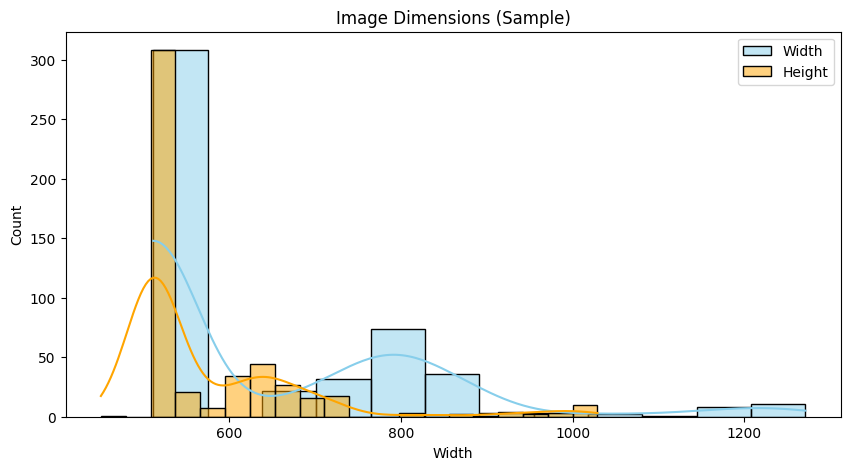

Corrupt images found: 0


In [ ]:
# ===============================
# 4. Image Shape Consistency
# ===============================

shapes = []
corrupt = 0

# Sample 500 images to check sizes
for path in df['filepath'].sample(500):
    try:
        with Image.open(path) as img:
            shapes.append(img.size)
    except:
        corrupt += 1

shape_df = pd.DataFrame(shapes, columns=['Width', 'Height'])

# Plot histograms for width and height
plt.figure(figsize=(10, 5))
sns.histplot(shape_df['Width'], color='skyblue', label='Width', kde=True)
sns.histplot(shape_df['Height'], color='orange', label='Height', kde=True)
plt.legend()
plt.title("Image Dimensions (Sample)")
plt.show()

print("Corrupt images found:", corrupt)


# Train-Validation-Test Split

In [ ]:
# ====================================
# 5. Train, Validation, Test Split
# ====================================

train_df, temp_df = train_test_split(df, test_size=0.3, stratify=df['label'], random_state=19)
valid_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['label'], random_state=19)

print("Train size:", train_df.shape)
print("Validation size:", valid_df.shape)
print("Test size:", test_df.shape)

# Confirm label balance across splits
for split_name, split_df in zip(["Train", "Validation", "Test"], [train_df, valid_df, test_df]):
    print(f"\n{split_name} split distribution:\n", split_df['label'].value_counts(normalize=True))


Train size: (8712, 2)
Validation size: (1867, 2)
Test size: (1867, 2)

Train split distribution:
 label
Normal    0.407943
Cyst      0.297980
Tumor     0.183425
Stone     0.110652
Name: proportion, dtype: float64

Validation split distribution:
 label
Normal    0.407606
Cyst      0.298340
Tumor     0.183717
Stone     0.110337
Name: proportion, dtype: float64

Test split distribution:
 label
Normal    0.408141
Cyst      0.297804
Tumor     0.183182
Stone     0.110873
Name: proportion, dtype: float64


# Plot Label Distributions for Splits

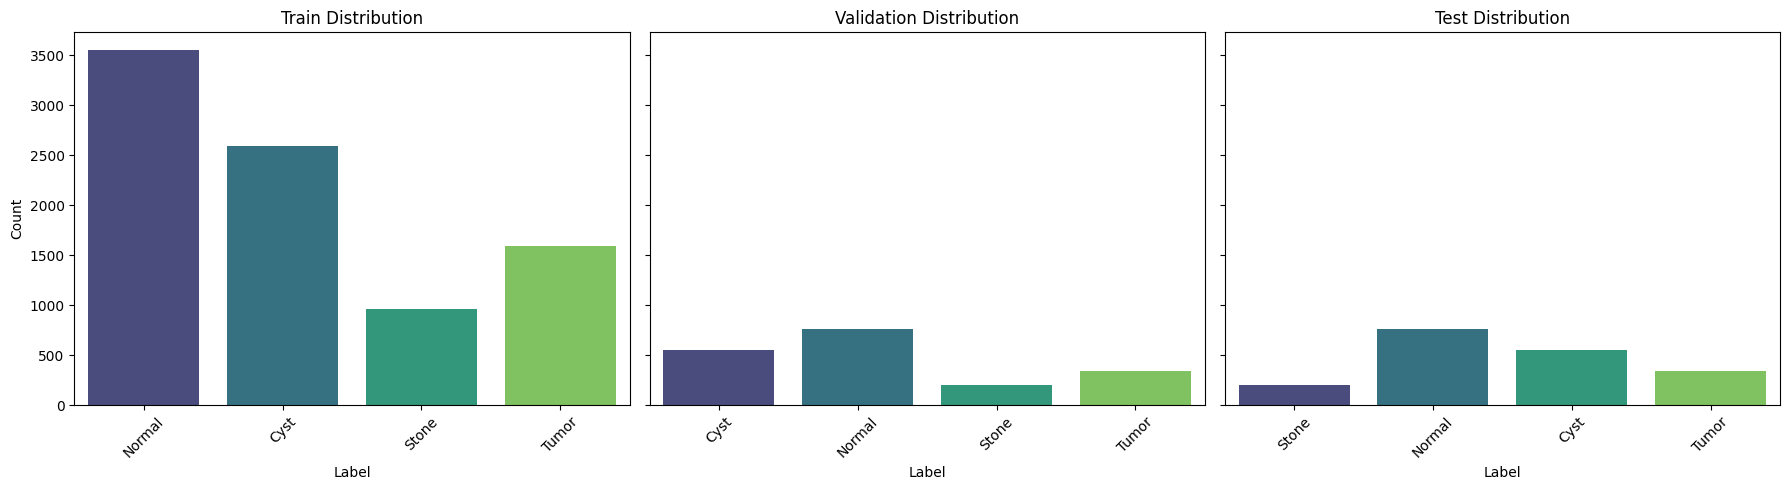

In [ ]:
# ==============================
# 6. Label Distribution Plots
# ==============================

def plot_split_distributions(train, valid, test):
    fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)
    for ax, df_split, name in zip(axes, [train, valid, test], ["Train", "Validation", "Test"]):
        sns.countplot(data=df_split, x='label', ax=ax, palette='viridis')
        ax.set_title(f'{name} Distribution')
        ax.set_xlabel('Label')
        ax.set_ylabel('Count')
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    plt.tight_layout()
    plt.show()

plot_split_distributions(train_df, valid_df, test_df)


# Image Orientation and Aspect Ratio Analysis

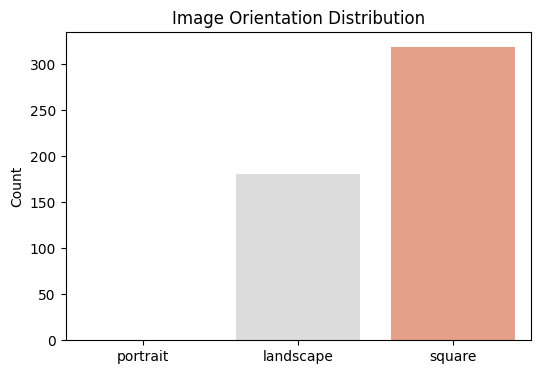

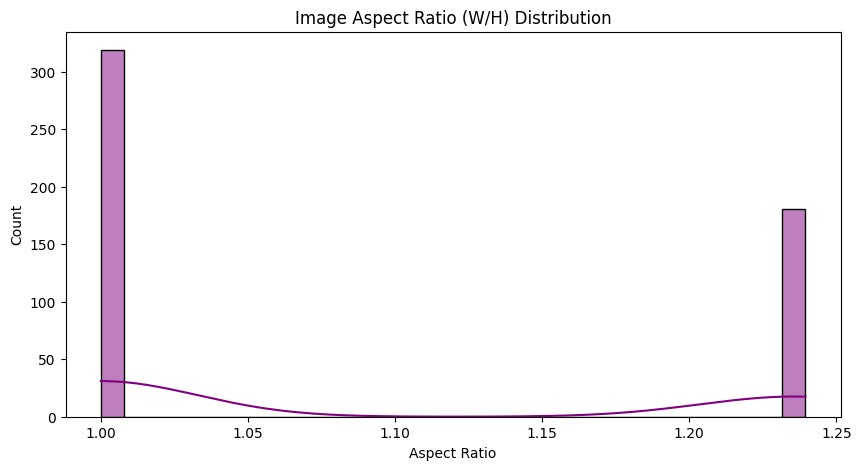

In [ ]:
# ======================================
# 7. Image Aspect Ratio and Orientation
# ======================================

aspect_ratios = []
orientations = {"portrait": 0, "landscape": 0, "square": 0}

for path in df['filepath'].sample(500):
    try:
        img = Image.open(path)
        w, h = img.size
        aspect_ratios.append(w / h)
        if w > h:
            orientations['landscape'] += 1
        elif h > w:
            orientations['portrait'] += 1
        else:
            orientations['square'] += 1
    except:
        continue

# Plot image orientation counts
plt.figure(figsize=(6, 4))
sns.barplot(x=list(orientations.keys()), y=list(orientations.values()), palette='coolwarm')
plt.title("Image Orientation Distribution")
plt.ylabel("Count")
plt.show()

# Plot aspect ratio histogram
plt.figure(figsize=(10, 5))
sns.histplot(aspect_ratios, bins=30, kde=True, color='purple')
plt.title("Image Aspect Ratio (W/H) Distribution")
plt.xlabel("Aspect Ratio")
plt.show()


# File Size Analysis

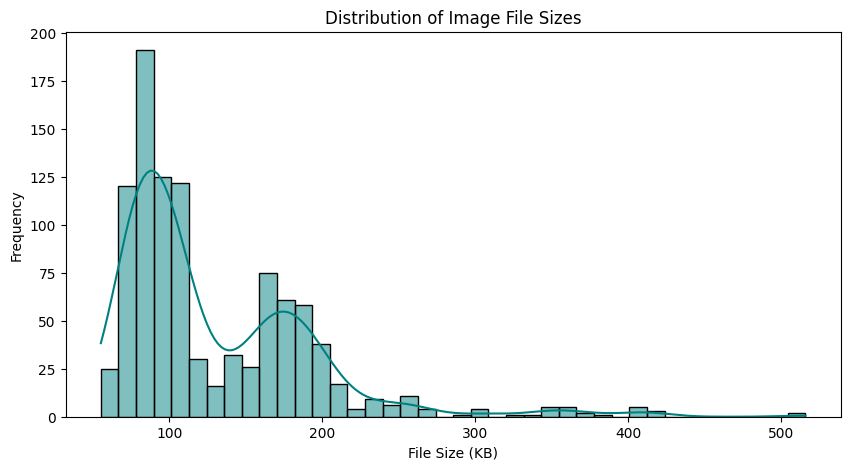

Mean file size: 130.06 KB
Max file size: 515.95 KB
Min file size: 55.36 KB


In [ ]:
# =======================
# 8. Analyzing the File Sizes of Images
# =======================

file_sizes_kb = [os.path.getsize(p) / 1024 for p in df['filepath'].sample(1000)]

plt.figure(figsize=(10, 5))
sns.histplot(file_sizes_kb, bins=40, kde=True, color='teal')
plt.title("Distribution of Image File Sizes")
plt.xlabel("File Size (KB)")
plt.ylabel("Frequency")
plt.show()

print(f"Mean file size: {np.mean(file_sizes_kb):.2f} KB")
print(f"Max file size: {np.max(file_sizes_kb):.2f} KB")
print(f"Min file size: {np.min(file_sizes_kb):.2f} KB")


In [ ]:
# ================================================================
# 5. Data Generators For Model Training, Validation and Testing
# ================================================================

img_size = (128, 128)
batch_size = 32

class_names = sorted(df['label'].unique())

train_gen = ImageDataGenerator(rescale=1./255, rotation_range=10, zoom_range=0.1, horizontal_flip=True)
val_test_gen = ImageDataGenerator(rescale=1./255)

train_data = train_gen.flow_from_dataframe(train_df, x_col='filepath', y_col='label',
                                           target_size=img_size, batch_size=batch_size, class_mode='categorical',
                                           classes=class_names)
val_data = val_test_gen.flow_from_dataframe(valid_df, x_col='filepath', y_col='label',
                                            target_size=img_size, batch_size=batch_size, class_mode='categorical',
                                            classes=class_names)
test_data = val_test_gen.flow_from_dataframe(test_df, x_col='filepath', y_col='label',
                                             target_size=img_size, batch_size=batch_size, class_mode='categorical',
                                             classes=class_names, shuffle=False)

num_classes = len(class_names)
input_shape = (128, 128, 3)

Found 8712 validated image filenames belonging to 4 classes.
Found 1867 validated image filenames belonging to 4 classes.
Found 1867 validated image filenames belonging to 4 classes.


In [ ]:
# ============================================
# 6. Define Models
# ============================================

def create_mobilenet():
    base = MobileNetV2(include_top=False, input_shape=input_shape, weights='imagenet')
    base.trainable = False
    x = base.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    output = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base.input, outputs=output)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def create_cnn():
    model = Sequential([
        Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
        MaxPooling2D(2,2),
        Conv2D(64, (3,3), activation='relu'),
        MaxPooling2D(2,2),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def create_lenet():
    model = Sequential([
        Conv2D(6, (5,5), activation='tanh', input_shape=input_shape, padding='same'),
        AveragePooling2D(pool_size=(2,2)),
        Conv2D(16, (5,5), activation='tanh'),
        AveragePooling2D(pool_size=(2,2)),
        Flatten(),
        Dense(120, activation='tanh'),
        Dense(84, activation='tanh'),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
# ============================================
# 7. Train and Evaluate Models
# ============================================

def train_and_evaluate(model, model_name):
    print(f"\n  Training {model_name}...\n")
    history = model.fit(train_data, validation_data=val_data, epochs=10)

    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{model_name} Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    preds = model.predict(test_data)
    y_pred = np.argmax(preds, axis=1)
    y_true = test_data.classes

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names,
                yticklabels=class_names, cmap='Blues')
    plt.title(f'{model_name} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    print(f"\n {model_name} Classification Report:\n")
    print(classification_report(y_true, y_pred, target_names=class_names))

    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average='macro')
    rec = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')
    print(f"\n {model_name} Metrics:")
    print(f"Accuracy:  {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall:    {rec:.4f}")
    print(f"F1 Score:  {f1:.4f}")


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

  Training MobileNetV2...

Epoch 1/10
273/273 ━━━━━━━━━━━━━━━━━━━━ 217s 766ms/step - accuracy: 0.7049 - loss: 0.8133 - val_accuracy: 0.8704 - val_loss: 0.3797
Epoch 2/10
273/273 ━━━━━━━━━━━━━━━━━━━━ 249s 721ms/step - accuracy: 0.9197 - loss: 0.2542 - val_accuracy: 0.8929 - val_loss: 0.2849
Epoch 3/10
273/273 ━━━━━━━━━━━━━━━━━━━━ 193s 707ms/step - accuracy: 0.9427 - loss: 0.1679 - val_accuracy: 0.9330 - val_loss: 0.1828
Epoch 4/10
273/273 ━━━━━━━━━━━━━━━━━━━━ 212s 777ms/step - accuracy: 0.9611 - loss: 0.1102 - val_accuracy: 0.9213 - val_loss: 0.2115
Epoch 5/10
273/273 ━━━━━━━━━━━━━━━━━━━━ 216s 792ms/step - accuracy: 0.9572 - loss: 0.1177 - val_accuracy: 0.9314 - val_loss: 0.1928
Epoch 6/10
273/273 ━━━━━━━━━━━━━━━━━━━━ 204s 749ms/step - accuracy: 0.9720 - loss: 0.0803 - val_accuracy: 0.9432 - val_loss: 0.1621
Epoch 7/10
273/273 ━━━━━━━━━━━━━━━━━━━━ 261s 744ms/step - accuracy: 0.9812 - loss: 0.0615 - val_accuracy: 0.9497 - val_loss: 0.1373

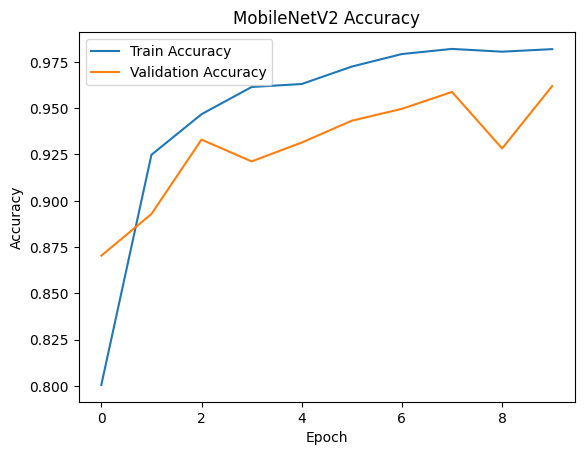

59/59 ━━━━━━━━━━━━━━━━━━━━ 32s 497ms/step


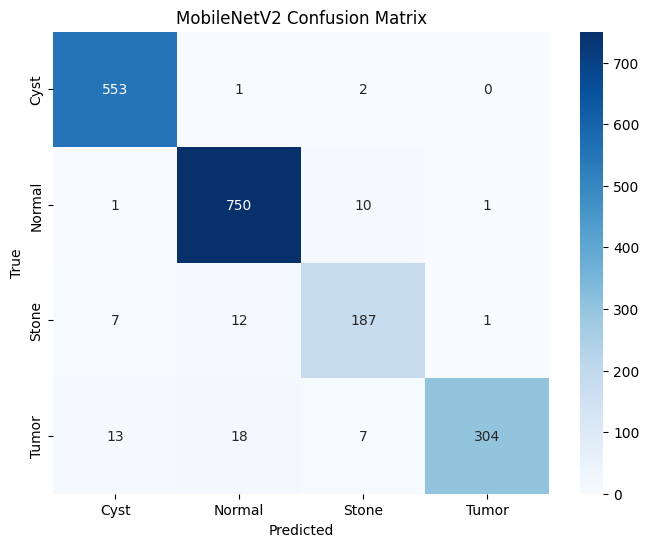


 MobileNetV2 Classification Report:

              precision    recall  f1-score   support

        Cyst       0.96      0.99      0.98       556
      Normal       0.96      0.98      0.97       762
       Stone       0.91      0.90      0.91       207
       Tumor       0.99      0.89      0.94       342

    accuracy                           0.96      1867
   macro avg       0.96      0.94      0.95      1867
weighted avg       0.96      0.96      0.96      1867


 MobileNetV2 Metrics:
Accuracy:  0.9609
Precision: 0.9562
Recall:    0.9428
F1 Score:  0.9487

  Training Custom CNN...

Epoch 1/10
273/273 ━━━━━━━━━━━━━━━━━━━━ 284s 1s/step - accuracy: 0.6227 - loss: 1.0067 - val_accuracy: 0.9031 - val_loss: 0.2446
Epoch 2/10
273/273 ━━━━━━━━━━━━━━━━━━━━ 280s 1s/step - accuracy: 0.8866 - loss: 0.3057 - val_accuracy: 0.9877 - val_loss: 0.0674
Epoch 3/10
273/273 ━━━━━━━━━━━━━━━━━━━━ 286s 1s/step - accuracy: 0.9372 - loss: 0.1796 - val_accuracy: 0.9834 - val_loss: 0.0661
Epoch 4/10
273/273

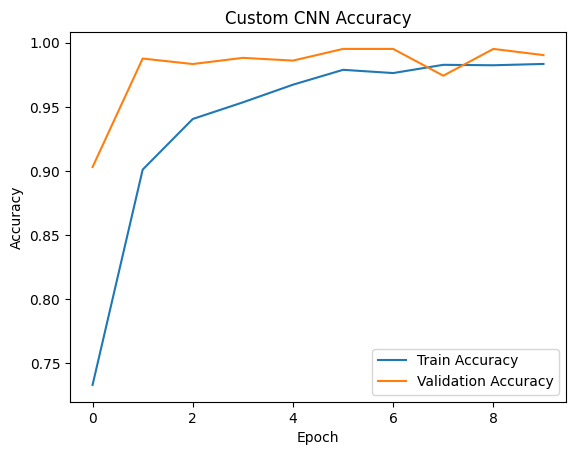

59/59 ━━━━━━━━━━━━━━━━━━━━ 18s 306ms/step


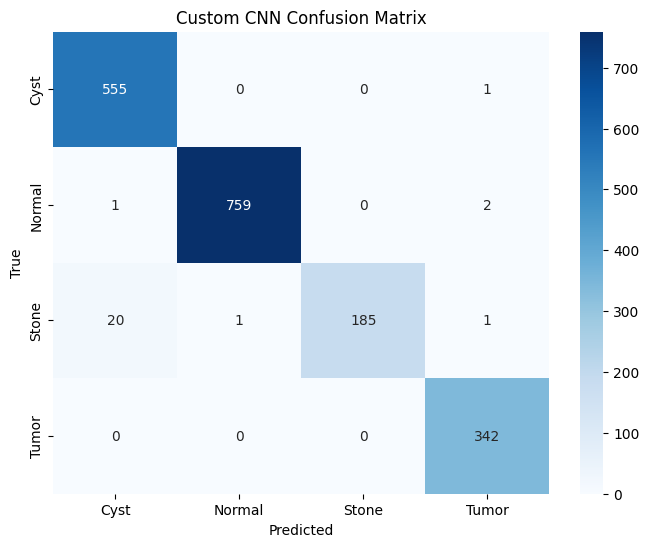


 Custom CNN Classification Report:

              precision    recall  f1-score   support

        Cyst       0.96      1.00      0.98       556
      Normal       1.00      1.00      1.00       762
       Stone       1.00      0.89      0.94       207
       Tumor       0.99      1.00      0.99       342

    accuracy                           0.99      1867
   macro avg       0.99      0.97      0.98      1867
weighted avg       0.99      0.99      0.99      1867


 Custom CNN Metrics:
Accuracy:  0.9861
Precision: 0.9877
Recall:    0.9720
F1 Score:  0.9790

  Training LeNet...

Epoch 1/10
273/273 ━━━━━━━━━━━━━━━━━━━━ 188s 682ms/step - accuracy: 0.6443 - loss: 0.9850 - val_accuracy: 0.8763 - val_loss: 0.3555
Epoch 2/10
273/273 ━━━━━━━━━━━━━━━━━━━━ 185s 676ms/step - accuracy: 0.8825 - loss: 0.3328 - val_accuracy: 0.9700 - val_loss: 0.1275
Epoch 3/10
273/273 ━━━━━━━━━━━━━━━━━━━━ 184s 672ms/step - accuracy: 0.9276 - loss: 0.2111 - val_accuracy: 0.9780 - val_loss: 0.0814
Epoch 4/10
273/2

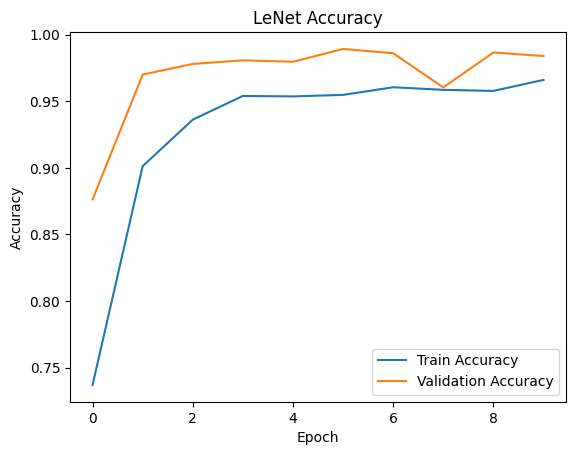

In [ ]:
mobilenet = create_mobilenet()
train_and_evaluate(mobilenet, "MobileNetV2")

cnn = create_cnn()
train_and_evaluate(cnn, "Custom CNN")

lenet = create_lenet()
train_and_evaluate(lenet, "LeNet")